# Predicting the stock price of Nifty50 tomorrow
* Given prices and other features for the last N days, we do prediction for day N+1
* Predict stock price in next day using XGBoost
* Here we split 4 years of data into train (upto 2023), validation (2023) and test (2024) set

In [11]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "/kaggle/input/nifty50/NSEI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                               # Essentially is using data from previous N days

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Defining Functions

In [12]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

In [13]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

# Loading the data into a dataframe

In [15]:
df = pd.read_csv(stk_path)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,19-06-2020,10119.00000,10272.40039,10072.65039,10244.40039,10244.40039,892100
1,22-06-2020,10318.75000,10393.65039,10277.59961,10311.20020,10311.20020,685400
2,23-06-2020,10347.95020,10484.70020,10301.75000,10471.00000,10471.00000,669200
3,24-06-2020,10529.25000,10553.15039,10281.95020,10305.29981,10305.29981,854800
4,25-06-2020,10235.54981,10361.79981,10194.50000,10288.90039,10288.90039,994200
...,...,...,...,...,...,...,...
986,12-06-2024,23344.44922,23441.94922,23295.94922,23322.94922,23322.94922,295600
987,13-06-2024,23480.94922,23481.05078,23353.90039,23398.90039,23398.90039,268300
988,14-06-2024,23464.94922,23490.40039,23334.25000,23465.59961,23465.59961,223100
989,18-06-2024,23570.80078,23579.05078,23499.69922,23557.90039,23557.90039,272200


**Checking for NaN values**

In [16]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [18]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [19]:
type(df.date)

pandas.core.series.Series

In [20]:
# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2020-06-19,10119.00000,10272.40039,10072.65039,10244.40039,10244.40039,892100,6
1,2020-06-22,10318.75000,10393.65039,10277.59961,10311.20020,10311.20020,685400,6
2,2020-06-23,10347.95020,10484.70020,10301.75000,10471.00000,10471.00000,669200,6
3,2020-06-24,10529.25000,10553.15039,10281.95020,10305.29981,10305.29981,854800,6
4,2020-06-25,10235.54981,10361.79981,10194.50000,10288.90039,10288.90039,994200,6


Text(0, 0.5, 'INR')

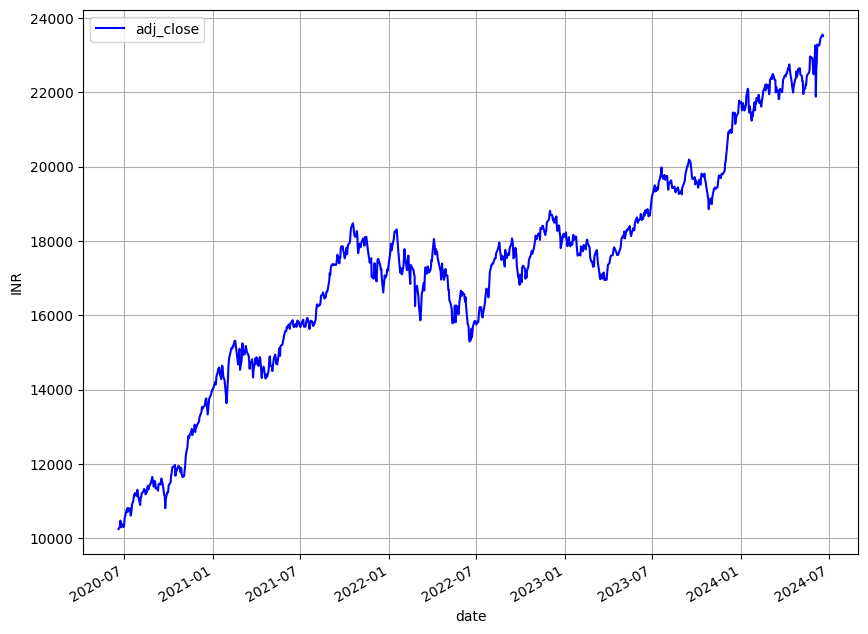

In [21]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("INR")

# Feature Engineering
We will generate the following features:

* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [22]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

In [23]:
# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2020-06-19,10244.40039,892100,6,199.75000,-125.40039
1,2020-06-22,10311.20020,685400,6,116.05078,7.54980
2,2020-06-23,10471.00000,669200,6,182.95020,-123.04980
3,2020-06-24,10305.29981,854800,6,271.20019,223.95019
4,2020-06-25,10288.90039,994200,6,167.29981,-53.35058


Now we use lags up to N number of days to use as features.

In [24]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

In [25]:
df

,date,adj_close,volume,month,range_hl,range_oc,order_day
0,2020-06-19,10244.40039,892100,6,199.75000,-125.40039,0
1,2020-06-22,10311.20020,685400,6,116.05078,7.54980,1
2,2020-06-23,10471.00000,669200,6,182.95020,-123.04980,2
3,2020-06-24,10305.29981,854800,6,271.20019,223.95019,3
4,2020-06-25,10288.90039,994200,6,167.29981,-53.35058,4
...,...,...,...,...,...,...,...
986,2024-06-12,23322.94922,295600,6,146.00000,21.50000,986
987,2024-06-13,23398.90039,268300,6,127.15039,82.04883,987
988,2024-06-14,23465.59961,223100,6,156.15039,-0.65039,988
989,2024-06-18,23557.90039,272200,6,79.35156,12.90039,989


In [26]:
# merging_keys --> to merge dataframes later
merging_keys = ['order_day']

In [27]:
# List of columns that we will use to create lags

#"lags" refer to the delay between an event, action, or signal and its effect on the market or the observed data

lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [28]:
N

3

In [29]:
shift_range = [x+1 for x in range(N)]

In [30]:
#tqdm_notebook is a function from the tqdm library, 
#which is used to create progress bars in Jupyter notebooks.

In [31]:
for shift in shift_range:
    train_shift = df[merging_keys + lag_cols].copy()
    #creating a training dataframe with merging_keys and lag_cols
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    #order_day values are incremented as shift iterates
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

In [32]:
df

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
0,2020-06-19,10244.40039,892100,6,199.75000,-125.40039,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-22,10311.20020,685400,6,116.05078,7.54980,1,10244.40039,199.75000,-125.40039,892100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-06-23,10471.00000,669200,6,182.95020,-123.04980,2,10311.20020,116.05078,7.54980,685400.0,10244.40039,199.75000,-125.40039,892100.0,NaN,NaN,NaN,NaN
3,2020-06-24,10305.29981,854800,6,271.20019,223.95019,3,10471.00000,182.95020,-123.04980,669200.0,10311.20020,116.05078,7.54980,685400.0,10244.40039,199.75000,-125.40039,892100.0
4,2020-06-25,10288.90039,994200,6,167.29981,-53.35058,4,10305.29981,271.20019,223.95019,854800.0,10471.00000,182.95020,-123.04980,669200.0,10311.20020,116.05078,7.54980,685400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,2024-06-12,23322.94922,295600,6,146.00000,21.50000,986,23264.84961,182.79883,18.90039,305200.0,23259.19922,184.75000,59.95117,304400.0,23290.15039,531.14844,-468.30078,473600.0
987,2024-06-13,23398.90039,268300,6,127.15039,82.04883,987,23322.94922,146.00000,21.50000,295600.0,23264.84961,182.79883,18.90039,305200.0,23259.19922,184.75000,59.95117,304400.0
988,2024-06-14,23465.59961,223100,6,156.15039,-0.65039,988,23398.90039,127.15039,82.04883,268300.0,23322.94922,146.00000,21.50000,295600.0,23264.84961,182.79883,18.90039,305200.0
989,2024-06-18,23557.90039,272200,6,79.35156,12.90039,989,23465.59961,156.15039,-0.65039,223100.0,23398.90039,127.15039,82.04883,268300.0,23322.94922,146.00000,21.50000,295600.0


In [33]:
# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2020-06-24,10305.29981,854800,6,271.20019,223.95019,3,10471.00000,182.95020,-123.04980,669200.0,10311.20020,116.05078,7.54980,685400.0,10244.40039,199.75000,-125.40039,892100.0
4,2020-06-25,10288.90039,994200,6,167.29981,-53.35058,4,10305.29981,271.20019,223.95019,854800.0,10471.00000,182.95020,-123.04980,669200.0,10311.20020,116.05078,7.54980,685400.0
5,2020-06-26,10383.00000,671900,6,98.59961,-4.09961,5,10288.90039,167.29981,-53.35058,994200.0,10305.29981,271.20019,223.95019,854800.0,10471.00000,182.95020,-123.04980,669200.0
6,2020-06-29,10312.40039,574500,6,114.35059,-0.45019,6,10383.00000,98.59961,-4.09961,671900.0,10288.90039,167.29981,-53.35058,994200.0,10305.29981,271.20019,223.95019,854800.0
7,2020-06-30,10302.09961,556200,6,133.70020,80.50000,7,10312.40039,114.35059,-0.45019,574500.0,10383.00000,98.59961,-4.09961,671900.0,10288.90039,167.29981,-53.35058,994200.0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 3 to 990
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             988 non-null    datetime64[ns]
 1   adj_close        988 non-null    float64       
 2   volume           988 non-null    int64         
 3   month            988 non-null    int32         
 4   range_hl         988 non-null    float64       
 5   range_oc         988 non-null    float64       
 6   order_day        988 non-null    int64         
 7   adj_close_lag_1  988 non-null    float64       
 8   range_hl_lag_1   988 non-null    float64       
 9   range_oc_lag_1   988 non-null    float64       
 10  volume_lag_1     988 non-null    float64       
 11  adj_close_lag_2  988 non-null    float64       
 12  range_hl_lag_2   988 non-null    float64       
 13  range_oc_lag_2   988 non-null    float64       
 14  volume_lag_2     988 non-null    float64  

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [35]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2020-06-24,10305.29981,854800,6,271.20019,223.95019,3,10471.00000,182.95020,-123.04980,...,-125.40039,892100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-06-25,10288.90039,994200,6,167.29981,-53.35058,4,10305.29981,271.20019,223.95019,...,7.54980,685400.0,10305.299810,NaN,271.200190,NaN,223.950190,NaN,854800.000000,NaN
5,2020-06-26,10383.00000,671900,6,98.59961,-4.09961,5,10288.90039,167.29981,-53.35058,...,-123.04980,669200.0,10297.100100,11.596141,219.250000,73.468663,85.299805,196.081255,924500.000000,98570.685297
6,2020-06-29,10312.40039,574500,6,114.35059,-0.45019,6,10383.00000,98.59961,-4.09961,...,223.95019,854800.0,10325.733400,50.267612,179.033203,86.896458,55.500000,147.945985,840300.000000,161638.516450
7,2020-06-30,10302.09961,556200,6,133.70020,80.50000,7,10312.40039,114.35059,-0.45019,...,-53.35058,994200.0,10328.100260,48.974979,126.750003,35.989421,-19.300127,29.544959,746866.666667,219663.431944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,2024-06-12,23322.94922,295600,6,146.00000,21.50000,986,23264.84961,182.79883,18.90039,...,-468.30078,473600.0,23271.399740,16.482472,299.565757,200.558860,-129.816407,293.853781,361066.666667,97457.546313
987,2024-06-13,23398.90039,268300,6,127.15039,82.04883,987,23322.94922,146.00000,21.50000,...,59.95117,304400.0,23282.332683,35.288228,171.182943,21.830878,33.450520,22.987014,301733.333333,5326.662495
988,2024-06-14,23465.59961,223100,6,156.15039,-0.65039,988,23398.90039,127.15039,82.04883,...,18.90039,305200.0,23328.899740,67.223206,151.983073,28.302563,40.816407,35.731975,289700.000000,19144.450893
989,2024-06-18,23557.90039,272200,6,79.35156,12.90039,989,23465.59961,156.15039,-0.65039,...,21.50000,295600.0,23395.816407,71.375182,143.100260,14.715854,34.299480,42.809581,262333.333333,36616.435290


# Split into train, validation and test set

In [36]:
# Split into train, cv, and test
year = pd.to_datetime(df.date).dt.year


train = df[year<2023]
cv = df[year == 2023]
train_cv = df[year<2024]
test = df[year == 2024]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (630, 27)
cv.shape = (245, 27)
train_cv.shape = (875, 27)
test.shape = (113, 27)


# Scale the train, validation and test set

In [37]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

In [38]:
cols_to_scale

['adj_close',
 'adj_close_lag_1',
 'range_hl_lag_1',
 'range_oc_lag_1',
 'volume_lag_1',
 'adj_close_lag_2',
 'range_hl_lag_2',
 'range_oc_lag_2',
 'volume_lag_2',
 'adj_close_lag_3',
 'range_hl_lag_3',
 'range_oc_lag_3',
 'volume_lag_3']

In [39]:
# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

scaler.mean_ = [1.56168196e+04 1.56047016e+04 1.87616525e+02 8.53409514e+00
 4.04331587e+05 1.55921940e+04 1.87424703e+02 8.77671511e+00
 4.04973333e+05 1.55796891e+04 1.87575497e+02 8.63758751e+00
 4.06081587e+05]
scaler.var_ = [5.26122569e+06 5.29328031e+06 8.38260391e+03 1.61710945e+04
 3.63170853e+10 5.32698453e+06 8.38684163e+03 1.61334734e+04
 3.64179646e+10 5.36206061e+06 8.37621065e+03 1.61585949e+04
 3.67226736e+10]
train_scaled.shape = (630, 13)


In [40]:
# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]

print("train_scaled.shape = " + str(train_scaled.shape))

train_scaled.head()

train_scaled.shape = (630, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-2.315663,-2.231352,-0.050967,-1.034744,1.389872,-2.288100,-0.779364,-0.009659,1.469473,-2.304051,0.133023,-1.054450,2.536212,2020-06-24,6
1,-2.322813,-2.303374,0.912918,1.693981,2.363790,-2.218863,-0.048859,-1.037860,1.384582,-2.275203,-0.781506,-0.008557,1.457580,2020-06-25,6
2,-2.281788,-2.310502,-0.221903,-0.486646,3.095278,-2.290656,0.914782,1.694044,2.357151,-2.206194,-0.050538,-1.035959,1.373043,2020-06-26,6
3,-2.312567,-2.269601,-0.972261,-0.099348,1.404040,-2.297762,-0.219753,-0.489123,3.087625,-2.277751,0.913715,1.693822,2.341568,2020-06-29,6
4,-2.317058,-2.300287,-0.800226,-0.070650,0.892942,-2.256991,-0.969921,-0.101374,1.398731,-2.284833,-0.221540,-0.487649,3.069005,2020-06-30,6


In [41]:
# Do scaling for train+dev set (dev= cross validation maybe??)
scaler_train_cv = StandardScaler()

train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])

print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)

train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]

print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

train_cv_scaled.head()

scaler_train_cv.mean_ = [1.65362756e+04 1.65234066e+04 1.77747782e+02 8.89367799e+00
 3.64782400e+05 1.65103009e+04 1.77739326e+02 8.97510544e+00
 3.65116457e+05 1.64972605e+04 1.77761956e+02 9.01133312e+00
 3.65842857e+05]
scaler_train_cv.var_ = [6.30495060e+06 6.31598298e+06 7.61143652e+03 1.41780908e+04
 3.17991575e+10 6.32835226e+06 7.61241723e+03 1.41720637e+04
 3.19156102e+10 6.34280638e+06 7.61296482e+03 1.41611777e+04
 3.22189844e+10]
train_cv_scaled.shape = (875, 13)
train_cv_scaled.shape = (875, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-2.481505,-2.408284,0.059631,-1.108100,1.707112,-2.464242,-0.707039,-0.011973,1.792805,-2.482779,0.252005,-1.129503,2.931852,2020-06-24,6
1,-2.488037,-2.474217,1.071167,1.806108,2.747919,-2.400719,0.059724,-1.109020,1.702125,-2.456255,-0.707273,-0.012282,1.780298,2020-06-25,6
2,-2.450561,-2.480742,-0.119756,-0.522746,3.529645,-2.466588,1.071195,1.805808,2.741031,-2.392804,0.059463,-1.109750,1.690045,2020-06-26,6
3,-2.478678,-2.443299,-0.907209,-0.109121,1.722253,-2.473107,-0.119652,-0.523541,3.521330,-2.458598,1.070897,1.806198,2.724049,2020-06-29,6
4,-2.482780,-2.471391,-0.726669,-0.078473,1.176053,-2.435700,-0.907054,-0.109829,1.717238,-2.465109,-0.119907,-0.524046,3.500666,2020-06-30,6


In [42]:
def scale_row(feat_values, mean, std):
    return (feat_values - mean) / std

In [43]:
# Do scaling for dev set
cv_scaled = cv[['date']]

for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

/tmp/ipykernel_33/2335857311.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
633,2023-01-02,-0.756552,1.133737,-0.377185,0.141443,0.921748,-1.063191,1.079514,-0.894703,-0.184811,-0.595913,1.154499,-0.558587
634,2023-01-03,0.638900,-1.152430,0.513530,-1.013121,0.026781,0.986341,-0.301238,1.115990,-0.814753,0.283595,-1.111169,0.827574
635,2023-01-04,0.823430,0.289336,-1.112766,-0.861645,-0.234892,1.096537,-0.591383,-0.563203,1.154586,-0.307744,1.117703,-0.809959
636,2023-01-05,-1.137088,0.742535,0.394554,1.129020,-0.774236,-0.354784,1.154614,-0.589526,-0.565089,0.078580,-1.036972,0.958392
637,2023-01-06,-0.766095,-0.365166,1.131261,0.614274,0.539622,-1.153896,0.256050,0.847080,-1.103129,1.041551,-0.089059,-0.952492


In [44]:
cols_list

['adj_close', 'range_hl', 'range_oc', 'volume']

In [45]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

/tmp/ipykernel_33/1467327157.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
878,2024-01-01,0.156414,0.912576,-1.068990,-0.884463,-0.200648,1.085111,0.948891,0.095382,-1.044274,-0.478758,1.149375,-0.670617
879,2024-01-02,-0.352937,-0.775675,1.128612,1.000011,-0.999989,-0.000022,0.270099,0.837208,-1.107307,-0.992530,-0.014776,1.007306
880,2024-01-03,-1.145306,0.699955,0.445351,0.954687,0.085177,-1.039864,1.132840,-0.760084,-0.372755,0.521527,-1.152956,0.631429
881,2024-01-04,-1.088724,0.211181,0.877543,-0.002130,1.001064,-0.998933,0.902071,0.173225,-1.075296,0.848971,0.253332,-1.102303
882,2024-01-05,0.533802,-1.153632,0.619830,-1.105924,0.265388,0.840536,-1.105695,0.841083,0.264612,0.896351,0.182235,-1.078585


# Split into x and y

In [46]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (630, 12)
y_train.shape = (630,)
X_cv.shape = (245, 12)
y_cv.shape = (245,)
X_train_cv.shape = (875, 12)
y_train_cv.shape = (875,)
X_sample.shape = (113, 12)
y_sample.shape = (113,)


In [47]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (630, 12)
y_train_scaled.shape = (630,)
X_cv_scaled.shape = (245, 12)
X_train_cv_scaled.shape = (875, 12)
y_train_cv_scaled.shape = (875,)
X_sample_scaled.shape = (113, 12)


# Performing exploratory data analysis

Text(0.5, 1.0, 'Without scaling')

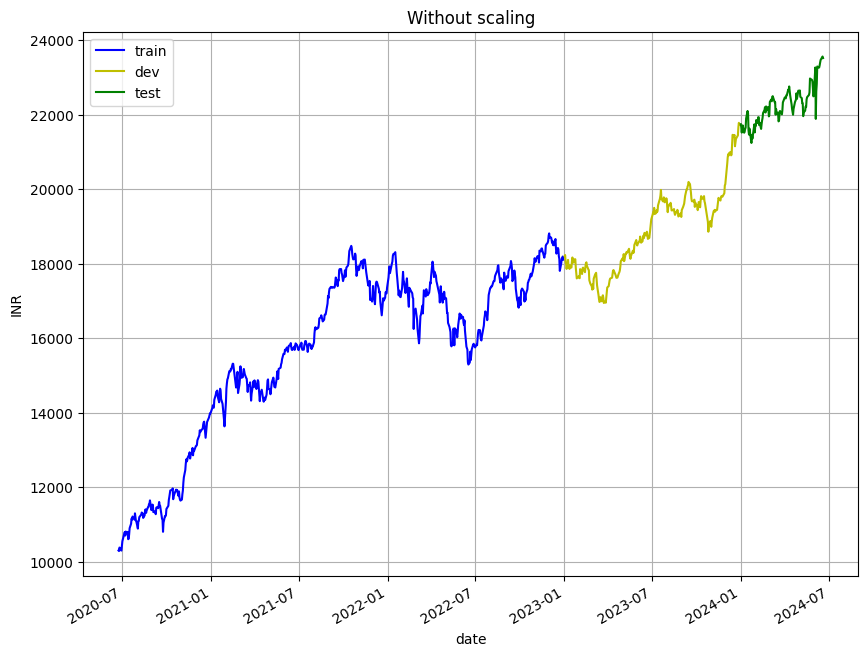

In [48]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("INR")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

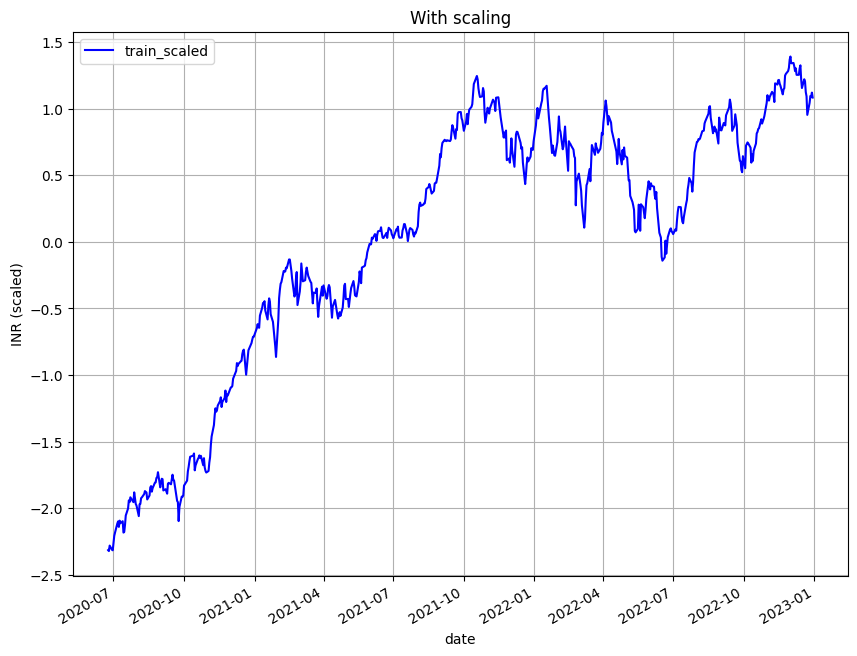

In [49]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("INR (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [50]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Performing prediction on training set

In [51]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 111.570
MAPE on train set = 0.547%


**Since working with data in 10,000's an error of 100 is actually good**

**A MAPE of 0.547% means that, on average, the forecasted values deviate from the actual values by only 0.547%. 
This level of accuracy is generally considered excellent in most forecasting contexts.**

We have industry standard MAPE as 10% or 5% normally

In [52]:
train_df=pd.DataFrame({"Prediction": est,
                      "Actual": y_train})

In [53]:
train_df

,Prediction,Actual
3,10436.651367,10305.29981
4,10396.443359,10288.90039
5,10436.376953,10383.00000
6,10382.544922,10312.40039
7,10369.898438,10302.09961
...,...,...
628,17875.529297,18014.59961
629,18135.802734,18132.30078
630,18099.105469,18122.50000
631,18160.871094,18191.00000


# Prediction on validation set

Text(0.5, 1.0, 'Without scaling')

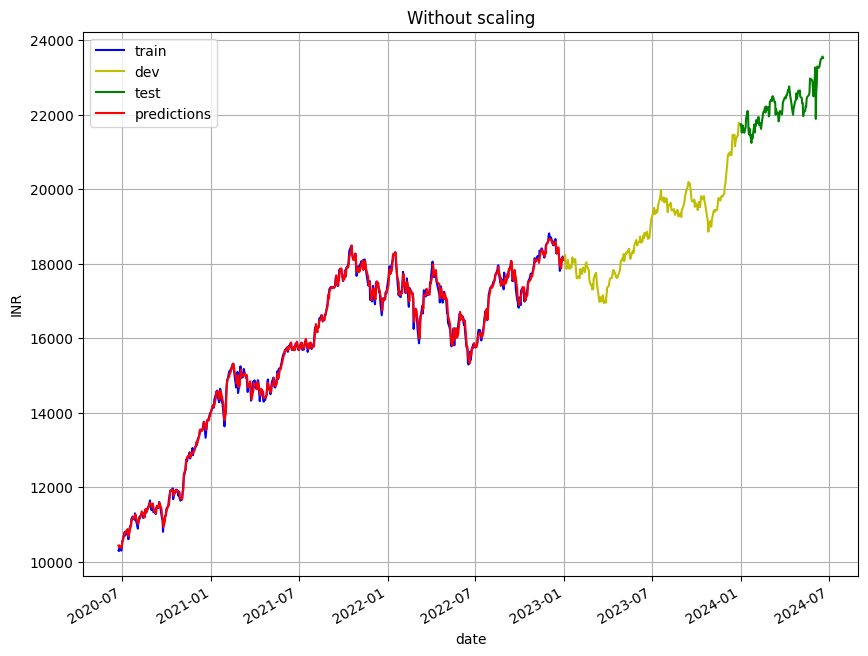

In [54]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("INR")
ax.set_title('Without scaling')

In [55]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 121.473
MAPE on dev set = 0.513%


/tmp/ipykernel_33/61816544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
/tmp/ipykernel_33/61816544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']


Text(0, 0.5, 'INR')

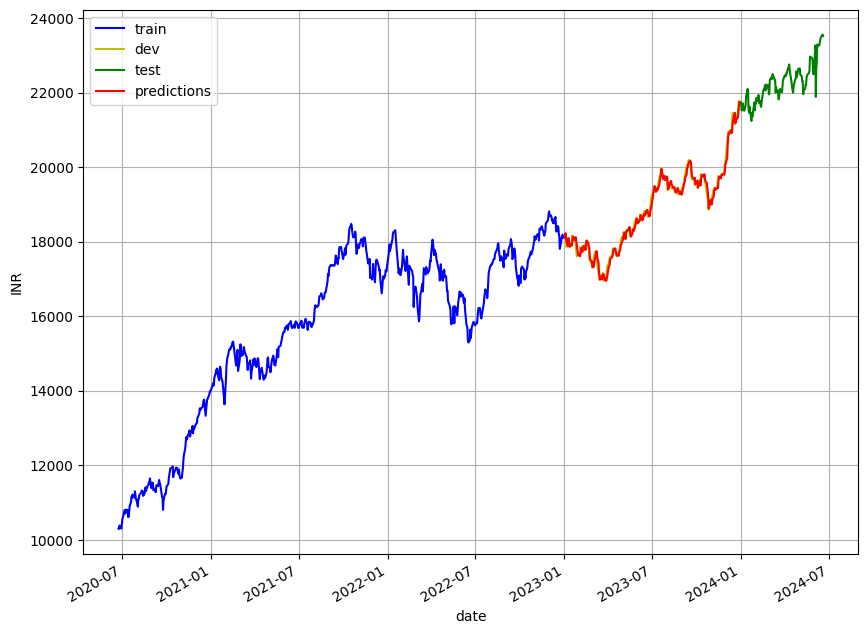

In [56]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("INR")

Text(0.5, 1.0, 'Zoom in to dev set')

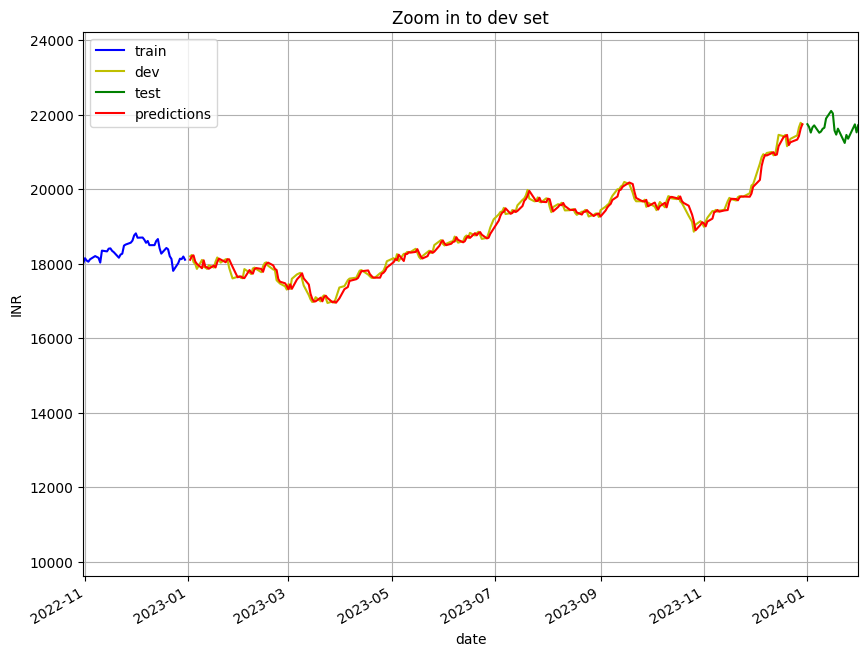

In [59]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("INR")
ax.set_xlim([date(2022, 10, 31), date(2024, 1, 31)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

In [60]:
importance_df=pd.DataFrame({'feature':train[features].keys(),
                           'importance':model.feature_importances_}).sort_values('importance',ascending=False)

In [61]:
importance_df

,feature,importance
0,adj_close_lag_1,0.756064
4,adj_close_lag_2,0.168588
8,adj_close_lag_3,0.067584
1,range_hl_lag_1,0.001354
3,volume_lag_1,0.001227
6,range_oc_lag_2,0.000984
7,volume_lag_2,0.000847
11,volume_lag_3,0.000748
10,range_oc_lag_3,0.000681
5,range_hl_lag_2,0.000662


**Importance features dominated by adj_close and volume**

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [ ]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

In [ ]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

In [ ]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

# Final model

In [62]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             learning_rate=learning_rate, 
                             min_child_weight=min_child_weight, 
                             subsample=subsample, 
                             colsample_bytree=colsample_bytree, 
                             colsample_bylevel=colsample_bylevel, 
                             gamma=gamma)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 222.935
MAPE on test set = 0.665%


In [63]:
rmse

222.9347269977267

In [64]:
result_df= pd.DataFrame({'Actual values':y_sample,
                        'Estimated values': est})

In [65]:
result_df

,Actual values,Estimated values
878,21741.90039,21727.803596
879,21665.80078,21742.675182
880,21517.34961,21673.279207
881,21658.59961,21534.068592
882,21710.80078,21657.004021
...,...,...
986,23322.94922,23266.136815
987,23398.90039,23315.825778
988,23465.59961,23381.057493
989,23557.90039,23452.251344


Text(0, 0.5, 'INR')

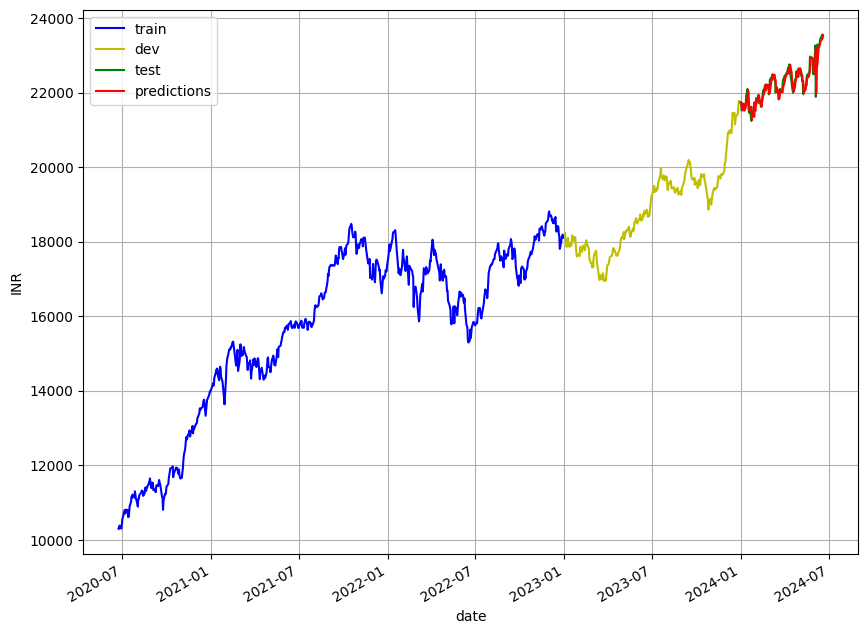

In [66]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("INR")

# Conclusion
1. By scaling the features properly, we can get good results for our predictions
2. RMSE and MAPE changed very little with hyperparameter tuning
3. The final RMSE and MAPE for test set are 222 and 0.66% respectively